In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import torch

from transformers import AutoTokenizer, AutoModel
# Sentence bert model for getting similarity
model_name = "sentence-transformers/stsb-distilbert-base"
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


In [5]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


def get_sent_embedding(sent, model, tokenizer): 
    #Tokenize sentences
    encoded_input = tokenizer(sent, padding=True, truncation=True, 
                              max_length=128, return_tensors='pt')
    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    #Perform pooling. In this case, mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embedding
    
def len_pen(sent_orig, sent_generated):
    encoded_input_orig = tokenizer(sent_orig, padding=True, truncation=True, 
                              max_length=128, return_tensors='pt') 
    len_orig = encoded_input_orig['attention_mask'].shape[1]
    
    encoded_input_generated = tokenizer(sent_generated, padding=True, truncation=True, 
                              max_length=128, return_tensors='pt') 
    len_generated = encoded_input_generated['attention_mask'].shape[1]
    return np.exp(1 - (np.max([len_orig, len_generated])/\
                       np.min([len_orig, len_generated])))
    
    
def get_similarity(sent_orig, sent_generated, model, 
                   tokenizer, length_penalty=True, alpha=0.4):
    embedding_orig =  get_sent_embedding(sent_orig, model, tokenizer)
    embedding_generated =  get_sent_embedding(sent_generated, model, tokenizer)
    sim = torch.nn.functional.cosine_similarity(embedding_orig, 
                                                embedding_generated, dim=1)
    if length_penalty:
        penalty = len_pen(sent_orig, sent_generated)
        sim *= penalty**alpha
    return sim
    

In [6]:
get_similarity('the world is a vampire', 'hello world', model, tokenizer)

tensor([-0.1039])

In [7]:
get_similarity('me and my friends really really like u', 
               'My friends and I quite like you.', model, tokenizer)

tensor([0.8769])

In [9]:
data_dir = '../data/pseudo/'
dataset = 'shakespeare'
mode = 'dev'
base_filename = f'{dataset}_{mode}_cross_predict_transfers.csv'
full_path = os.path.join(data_dir, dataset, base_filename)


parallel_df = pd.read_csv(full_path)

In [10]:
parallel_df.head()

,paraphrase,para_bucket,orig_text,oring_bucket,transfered1,transfered2,transfered3,pred_abstract_orig,pred_shakespeare_orig,pred_abstract_transfered1,pred_shakespeare_transfered1,pred_abstract_transfered2,pred_shakespeare_transfered2,pred_abstract_transfered3,pred_shakespeare_transfered3
0,I'm sure you won't marry her.,low,"But thus, I trust, you will not marry her.",mid,I am sure you will not marry her.,I know you will not marry her.,I am sure you’ll not marry her.,0.000403,0.000557,0.000232,0.002530,0.000307,0.050229,0.122297,0.998928
1,stand in front of the hearse!,low,Stand from the hearse.,mid,Stand in front of the hearse!,Stand in front of hearse!,Stand before the hearse!,0.000320,0.012139,0.000320,0.012139,0.000438,0.040431,0.062622,0.998390
2,"I'm not going to walk out of the door, but som...",low,"I have no will to wander forth of doors, Yet s...",high,"I’ll not walk out of the door, But something l...","I’ll not walk out of the door, but something l...","I will not walk out of the door, But something...",0.000409,0.000621,0.164337,0.998977,0.164337,0.998977,0.000302,0.026706
3,how do you mean removing him?,mid,"How do you mean, removing of him?",high,How mean you to remove him?,How dost thou mean removing him?,How mean you removing him?,0.000276,0.000980,0.006401,0.981065,0.204749,0.998964,0.006354,0.977889
4,I'm yours forever.,low,I am your own for ever.,high,I am yours forever.,I am thyself forever.,I am thy lord forever.,0.000332,0.000957,0.058799,0.997922,0.229949,0.999094,0.320483,0.999098


In [11]:
def get_sim_scores(row, orig_col, generated_cols, model, tokenizer):
    '''
    Get semantic similarity between an original 
    text and a set of generated texts. 
    
    This function is meant for applying to a row of a pd DataFrame 
    where 'col' is the name of the column that 
    contains the original text, 'generated_cols' are the names of
    the columns of generated text, and 'row' is the row of the DataFrame. 
    '''
    scores = {}
    sent_orig = row[orig_col]
    for col in generated_cols:
        sent_generated = row[col]
        score = get_similarity(sent_orig, sent_generated, model, tokenizer)
        scores[f"sim_score_{col}"] = score.item()
    return scores

In [8]:
parallel_df.head()

,paraphrase,para_bucket,orig_text,oring_bucket,transfered1,transfered2,transfered3,pred_abstract_orig,pred_shakespeare_orig,pred_abstract_transfered1,pred_shakespeare_transfered1,pred_abstract_transfered2,pred_shakespeare_transfered2,pred_abstract_transfered3,pred_shakespeare_transfered3
0,I'm sure you won't marry her.,low,"But thus, I trust, you will not marry her.",mid,I am sure you will not marry her.,I know you will not marry her.,I am sure you’ll not marry her.,0.000403,0.000557,0.000232,0.002530,0.000307,0.050229,0.122297,0.998928
1,stand in front of the hearse!,low,Stand from the hearse.,mid,Stand in front of the hearse!,Stand in front of hearse!,Stand before the hearse!,0.000320,0.012139,0.000320,0.012139,0.000438,0.040431,0.062622,0.998390
2,"I'm not going to walk out of the door, but som...",low,"I have no will to wander forth of doors, Yet s...",high,"I’ll not walk out of the door, But something l...","I’ll not walk out of the door, but something l...","I will not walk out of the door, But something...",0.000409,0.000621,0.164337,0.998977,0.164337,0.998977,0.000302,0.026706
3,how do you mean removing him?,mid,"How do you mean, removing of him?",high,How mean you to remove him?,How dost thou mean removing him?,How mean you removing him?,0.000276,0.000980,0.006401,0.981065,0.204749,0.998964,0.006354,0.977889
4,I'm yours forever.,low,I am your own for ever.,high,I am yours forever.,I am thyself forever.,I am thy lord forever.,0.000332,0.000957,0.058799,0.997922,0.229949,0.999094,0.320483,0.999098


In [13]:
orig_col = 'orig_text'
para_col = 'paraphrase'
generated_cols = ['transfered1', 'transfered2', 'transfered3']
orig_score_cols = [f"sim_score_orig_{col}" for col in generated_cols]
para_score_cols = [f"sim_score_para_{col}" for col in generated_cols]
temp = parallel_df.progress_apply(lambda x: get_sim_scores(x, orig_col, 
                                                           generated_cols, 
                                                           model, tokenizer), axis=1, result_type="expand")
parallel_df[orig_score_cols] = temp
temp = parallel_df.progress_apply(lambda x: get_sim_scores(x, para_col, 
                                                           generated_cols, 
                                                           model, tokenizer), axis=1, result_type="expand")
parallel_df[para_score_cols] = temp

In [14]:
parallel_df['sim_score_orig_para'] = parallel_df.progress_apply(lambda x: get_sim_scores(x, orig_col, 
                                                           [para_col], 
                                                           model, tokenizer), axis=1, result_type="expand")

100%|██████████| 7763/7763 [06:01<00:00, 21.49it/s]


In [25]:
parallel_df['best_sim_orig'] = parallel_df.apply(lambda x : 
                                                 np.max([x['sim_score_orig_transfered1'], 
                                                         x['sim_score_orig_transfered2'], 
                                                       x['sim_score_orig_transfered3']]), axis=1)
parallel_df['best_sim_para'] = parallel_df.apply(lambda x : np.max([x['sim_score_para_transfered1'], 
                                                       x['sim_score_para_transfered2'], 
                                                       x['sim_score_para_transfered3']]), axis=1)

In [26]:
parallel_df[f'{dataset}_diff1'] =  abs(parallel_df[f'pred_{dataset}_orig'] - parallel_df[f'pred_{dataset}_transfered1'])
parallel_df[f'{dataset}_diff2'] =  abs(parallel_df[f'pred_{dataset}_orig'] - parallel_df[f'pred_{dataset}_transfered2'])
parallel_df[f'{dataset}_diff3'] =  abs(parallel_df[f'pred_{dataset}_orig'] - parallel_df[f'pred_{dataset}_transfered3'])

parallel_df[f'{dataset}_para_diff1'] =  abs(parallel_df[f'pred_{dataset}_para'] - parallel_df[f'pred_{dataset}_transfered1'])
parallel_df[f'{dataset}_para_diff2'] =  abs(parallel_df[f'pred_{dataset}_para'] - parallel_df[f'pred_{dataset}_transfered2'])
parallel_df[f'{dataset}_para_diff3'] =  abs(parallel_df[f'pred_{dataset}_para'] - parallel_df[f'pred_{dataset}_transfered3'])

parallel_df[f'{dataset}_para_orig_diff'] = abs(parallel_df[f'pred_{dataset}_orig'] - parallel_df[f'pred_{dataset}_para'])

In [27]:
parallel_df[f'{dataset}_orig_diff_max'] = parallel_df.apply(lambda x : np.max([x[f'{dataset}_diff1'], 
                                                       x[f'{dataset}_diff2'], 
                                                       x[f'{dataset}_diff3']]), axis=1)

parallel_df[f'{dataset}_para_diff_max'] = parallel_df.apply(lambda x : np.max([x[f'{dataset}_para_diff1'], 
                                                       x[f'{dataset}_para_diff2'], 
                                                       x[f'{dataset}_para_diff3']]), axis=1)

Get the summary stats for style transfer eval metrics and for semantic similarity.

In [28]:
parallel_df['best_sim_orig'].describe()

count    7763.000000
mean        0.729944
std         0.161465
min         0.024768
25%         0.625262
50%         0.751123
75%         0.850518
max         1.000000
Name: best_sim_orig, dtype: float64

In [29]:
parallel_df['best_sim_para'].describe()

count    7763.000000
mean        0.878192
std         0.114952
min         0.193337
25%         0.825335
50%         0.907810
75%         0.959470
max         1.000000
Name: best_sim_para, dtype: float64

In [30]:
parallel_df[f'{dataset}_orig_diff_max'].describe()

count    7.763000e+03
mean     2.159519e-01
std      3.671728e-01
min      5.900000e-07
25%      1.608900e-04
50%      1.822900e-03
75%      2.625119e-01
max      9.985398e-01
Name: shakespeare_orig_diff_max, dtype: float64

In [31]:
parallel_df[f'{dataset}_para_diff_max'].describe()

count    7763.000000
mean        0.759769
std         0.391638
min         0.000000
25%         0.630386
50%         0.996468
75%         0.998343
max         0.998648
Name: shakespeare_para_diff_max, dtype: float64

Get the summary stats for style transfer eval metrics and for semantic similarity disaggregated by original class label

In [32]:
parallel_df[parallel_df['para_bucket']=='low']['best_sim_orig'].describe()

count    6324.000000
mean        0.728045
std         0.162354
min         0.024768
25%         0.622189
50%         0.746671
75%         0.849395
max         1.000000
Name: best_sim_orig, dtype: float64

In [33]:
parallel_df[parallel_df['para_bucket']=='mid']['best_sim_orig'].describe()

count    1439.000000
mean        0.738292
std         0.157287
min         0.046075
25%         0.642113
50%         0.764950
75%         0.854778
max         1.000000
Name: best_sim_orig, dtype: float64

In [34]:
parallel_df[parallel_df['para_bucket']=='low']['best_sim_para'].describe()

count    6324.000000
mean        0.867311
std         0.115444
min         0.193337
25%         0.813715
50%         0.895241
75%         0.949276
max         1.000000
Name: best_sim_para, dtype: float64

In [32]:
parallel_df[parallel_df['para_bucket']=='mid']['best_sim_para'].describe()

count    1439.000000
mean        0.926014
std         0.099579
min         0.363146
25%         0.895778
50%         0.959232
75%         1.000000
max         1.000000
Name: best_sim_para, dtype: float64

In [33]:
parallel_df[parallel_df['para_bucket']=='low'][f'{dataset}_diff_max'].describe()

count    6324.000000
mean        0.835582
std         0.333153
min         0.000000
25%         0.957236
50%         0.997673
75%         0.998396
max         0.998648
Name: shakespeare_diff_max, dtype: float64

In [34]:
parallel_df[parallel_df['para_bucket']=='mid'][f'{dataset}_diff_max'].describe()

count    1439.000000
mean        0.426594
std         0.451128
min         0.000000
25%         0.001393
50%         0.132307
75%         0.986538
max         0.998554
Name: shakespeare_diff_max, dtype: float64

In [19]:
parallel_df.tail()

,paraphrase,para_bucket,orig_text,oring_bucket,transfered1,transfered2,transfered3,pred_abstract_orig,pred_shakespeare_orig,pred_abstract_transfered1,...,sim_score_para_transfered1,sim_score_para_transfered2,sim_score_para_transfered3,best_sim_orig,best_sim_para,shakespeare_diff1,shakespeare_diff2,shakespeare_diff3,shakespeare_diff_max,sim_score_orig_para
7758,"I've got a couple of messengers, madam.",low,"Ay, madam, twenty several messengers.",high,"I have, madam, a couple of messengers.","I have several messengers, madam.","I have some messengers, madam.",0.000391,0.025393,0.150860,...,0.928515,0.676280,0.758674,0.693882,0.928515,0.973558,0.973632,0.973670,0.973670,0.629286
7759,I've never heard of it.,low,He never did harm that I heard of.,mid,I never heard of it.,I have never heard of it.,I never heard it.,0.000440,0.000589,0.000252,...,0.861740,0.948464,0.784896,0.341229,0.948464,0.013809,0.001492,0.365226,0.365226,0.318910
7760,he's not going to be admirable.,low,"Oh, ’twill be admirable!",high,He will not be admirable.,He shall not be admirable.,He is not admirable.,0.000464,0.000572,0.001245,...,0.850623,0.795869,0.745696,0.268062,0.850623,0.630548,0.998248,0.964660,0.998248,0.270434
7761,he hasn't claimed or deserved it.,low,This prince hath neither claimed it nor deserv...,high,He hath not claimed or deserved it.,He hath not claimed or deserved.,He hath not claimed nor deserved it.,0.000373,0.000608,0.054000,...,0.863301,0.779334,0.843626,0.457137,0.863301,0.997485,0.998338,0.998208,0.998338,0.370246
7762,"he's going to talk to you, are you?",low,"He’ll speak with you, will you or no.",mid,Will he speak with you?,Is he going to speak with you?,Shall he speak with you?,0.000426,0.000567,0.124832,...,0.620511,0.771445,0.612080,0.708556,0.771445,0.998396,0.021669,0.998566,0.998566,0.801397


In [16]:
out_filename = f'{dataset}_{mode}_cross_predict_transfers_sim_scores.csv'
full_path = os.path.join(data_dir, dataset, out_filename)
parallel_df.to_csv(full_path, index=False)

In [23]:
in_filename = f'{dataset}_{mode}_cross_predict_transfers_sim_scores.csv'
full_path = os.path.join(data_dir, dataset, in_filename)
parallel_df = pd.read_csv(full_path)

In [24]:
parallel_df.head()

,paraphrase,para_bucket,orig_text,oring_bucket,transfered1,transfered2,transfered3,pred_abstract_orig,pred_shakespeare_orig,pred_abstract_transfered1,...,sim_score_para_transfered3,best_sim_orig,best_sim_para,shakespeare_diff1,shakespeare_diff2,shakespeare_diff3,shakespeare_diff_max,sim_score_orig_para,pred_abstract_para,pred_shakespeare_para
0,I'm sure you won't marry her.,low,"But thus, I trust, you will not marry her.",mid,I am sure you will not marry her.,I know you will not marry her.,I am sure you’ll not marry her.,0.040968,0.997252,0.000232,...,0.911075,0.860139,0.911075,0.001974,0.049673,0.998371,0.998371,0.854544,0.000403,0.000557
1,stand in front of the hearse!,low,Stand from the hearse.,mid,Stand in front of the hearse!,Stand in front of hearse!,Stand before the hearse!,0.115325,0.998852,0.000320,...,0.796381,0.746643,1.000000,0.000000,0.028292,0.986251,0.986251,0.708459,0.000320,0.012139
2,"I'm not going to walk out of the door, but som...",low,"I have no will to wander forth of doors, Yet s...",high,"I’ll not walk out of the door, But something l...","I’ll not walk out of the door, but something l...","I will not walk out of the door, But something...",0.138364,0.998991,0.164337,...,0.877977,0.752635,0.913603,0.998356,0.998356,0.026085,0.998356,0.733736,0.000409,0.000621
3,how do you mean removing him?,mid,"How do you mean, removing of him?",high,How mean you to remove him?,How dost thou mean removing him?,How mean you removing him?,0.002919,0.918759,0.006401,...,0.935306,0.839476,0.954128,0.980085,0.997984,0.976909,0.997984,0.882690,0.000276,0.000980
4,I'm yours forever.,low,I am your own for ever.,high,I am yours forever.,I am thyself forever.,I am thy lord forever.,0.007673,0.983741,0.058799,...,0.775115,0.818798,0.939889,0.996964,0.998137,0.998141,0.998141,0.868843,0.000332,0.000957


In [35]:
parallel_df.columns

Index(['paraphrase', 'para_bucket', 'orig_text', 'oring_bucket', 'transfered1',
       'transfered2', 'transfered3', 'pred_abstract_orig',
       'pred_shakespeare_orig', 'pred_abstract_transfered1',
       'pred_shakespeare_transfered1', 'pred_abstract_transfered2',
       'pred_shakespeare_transfered2', 'pred_abstract_transfered3',
       'pred_shakespeare_transfered3', 'sim_score_orig_transfered1',
       'sim_score_orig_transfered2', 'sim_score_orig_transfered3',
       'sim_score_para_transfered1', 'sim_score_para_transfered2',
       'sim_score_para_transfered3', 'best_sim_orig', 'best_sim_para',
       'shakespeare_diff1', 'shakespeare_diff2', 'shakespeare_diff3',
       'shakespeare_diff_max', 'sim_score_orig_para', 'pred_abstract_para',
       'pred_shakespeare_para', 'shakespeare_para_diff1',
       'shakespeare_para_diff2', 'shakespeare_para_diff3',
       'shakespeare_para_orig_diff', 'shakespeare_orig_diff_max',
       'shakespeare_para_diff_max'],
      dtype='object')

In [36]:
print(f"## Summary Stats for {dataset} {mode}")
print('| Metric     | Mean | Std Dev|')
print('| ----------- | ----------- |--------|')
print(f"| Style difference between original and transfers | {parallel_df[f'{dataset}_orig_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_orig_diff_max'].std(): .4f} |")
print(f"| Style difference between paraphrase and transfers | {parallel_df[f'{dataset}_para_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_para_diff_max'].std(): .4f} |")
print(f"| Semantic similarity between original and transfers | {parallel_df['best_sim_orig'].mean(): .4f} | {parallel_df['best_sim_orig'].std(): .4f} |")
print(f"| Semantic similarity between paraphrase and transfers | {parallel_df['best_sim_para'].mean(): .4f} | {parallel_df['best_sim_para'].std(): .4f} |")

## Summary Stats for shakespeare dev
| Metric     | Mean | Std Dev|
| ----------- | ----------- |--------|
| Style difference between original and transfers |  0.2160 |  0.3672 |
| Style difference between paraphrase and transfers |  0.7598 |  0.3916 |
| Semantic similarity between original and transfers |  0.7299 |  0.1615 |
| Semantic similarity between paraphrase and transfers |  0.8782 |  0.1150 |


## Summary Stats for shakespeare dev
| Metric     | Mean | Std Dev|
| ----------- | ----------- |--------|
| Style difference between original and transfers |  0.2160 |  0.3672 |
| Style difference between paraphrase and transfers |  0.7598 |  0.3916 |
| Semantic similarity between original and transfers |  0.7299 |  0.1615 |
| Semantic similarity between paraphrase and transfers |  0.8782 |  0.1150 |

In [ ]:
print(f"## Summary Stats for {dataset} {mode}")
print('| Metric     | Mean | Std Dev|')
print('| ----------- | ----------- |--------|')
print(f"| Style difference between original and transfers | {parallel_df[f'{dataset}_orig_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_orig_diff_max'].std(): .4f} |")
print(f"| Style difference between paraphrase and transfers | {parallel_df[f'{dataset}_para_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_para_diff_max'].std(): .4f} |")
print(f"| Semantic similarity between original and transfers | {parallel_df['best_sim_orig'].mean(): .4f} | {parallel_df['best_sim_orig'].std(): .4f} |")
print(f"| Semantic similarity between paraphrase and transfers | {parallel_df['best_sim_para'].mean(): .4f} | {parallel_df['best_sim_para'].std(): .4f} |")

In [86]:
random_sample = parallel_df[parallel_df['para_bucket']=='low'].sample().iloc[0]
print(random_sample)
print('\n')
print(f"orig text:\n{random_sample['orig_text']}")
print(f"paraphrase:\n{random_sample['paraphrase']}")
print(f"transfers:\n{random_sample['transfered1']}")
print(f"{random_sample['transfered2']}")
print(f"{random_sample['transfered3']}")

paraphrase                          I'll also wear it on my cap.
para_bucket                                                  low
orig_text                       This will I also wear in my cap.
oring_bucket                                                high
transfered1                         I’ll wear it also on my cap.
transfered2                              I’ll wear ’t on my cap.
transfered3                         I’ll wear it also in my cap.
pred_abstract_orig                                      0.184128
pred_shakespeare_orig                                   0.999075
pred_abstract_transfered1                               0.273049
pred_shakespeare_transfered1                            0.999106
pred_abstract_transfered2                               0.336614
pred_shakespeare_transfered2                            0.999064
pred_abstract_transfered3                               0.287373
pred_shakespeare_transfered3                            0.999099
sim_score_orig_transfered

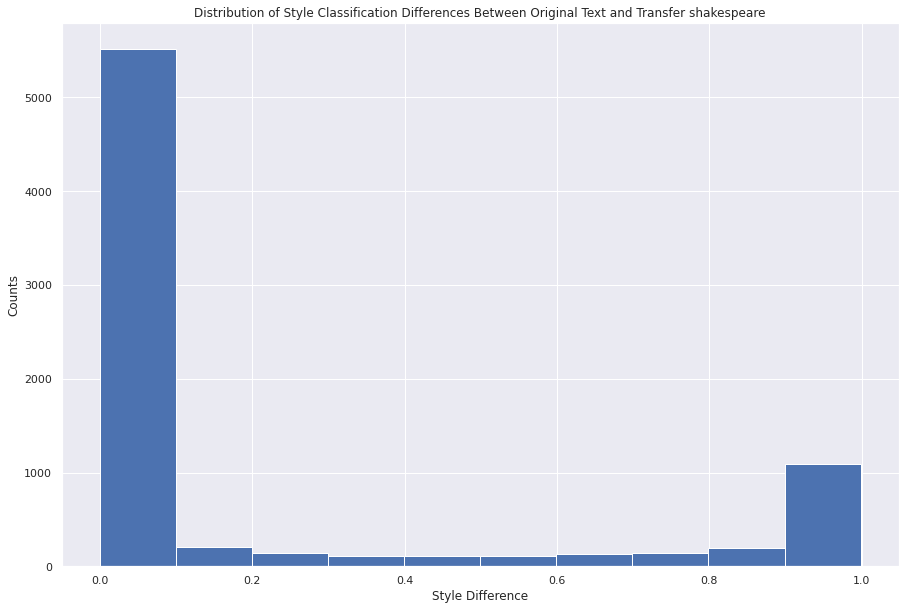

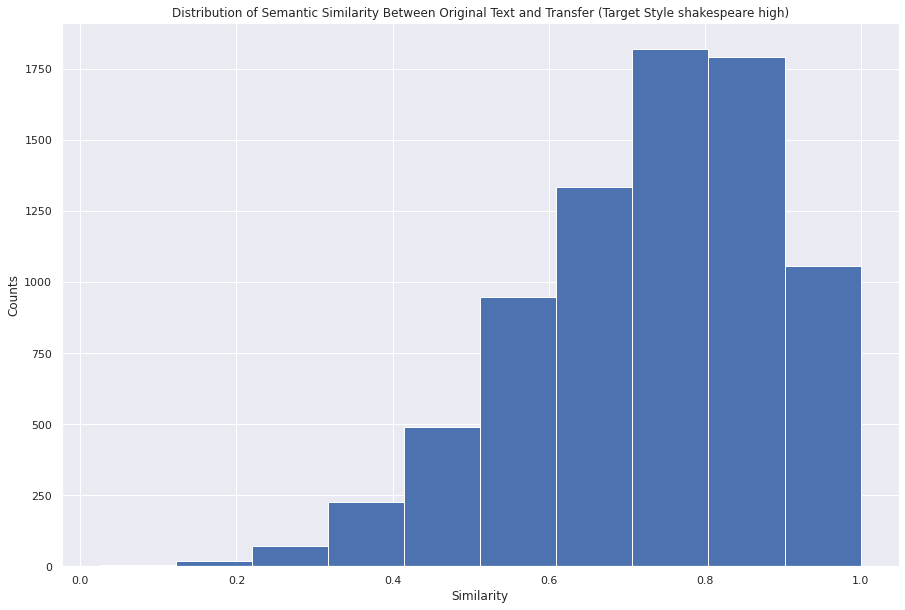

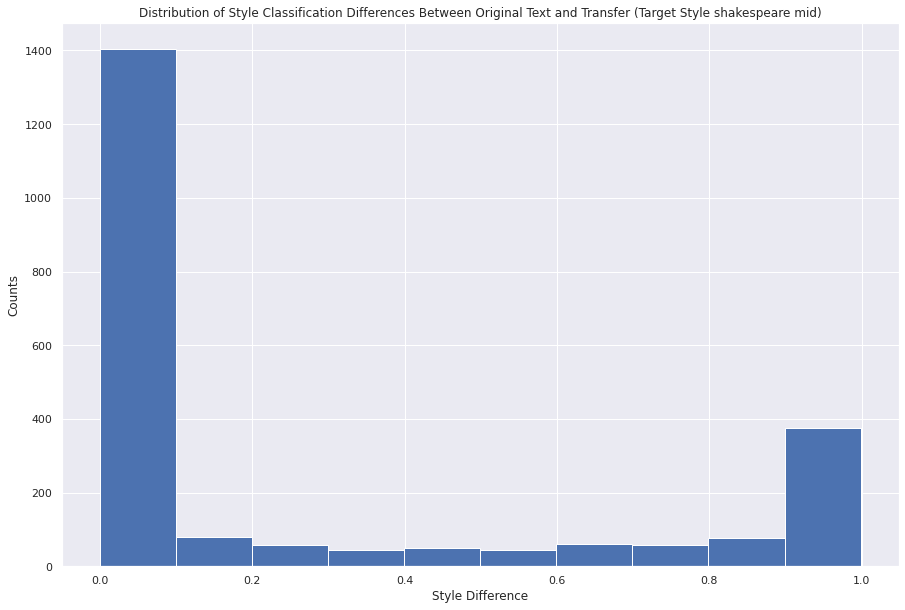

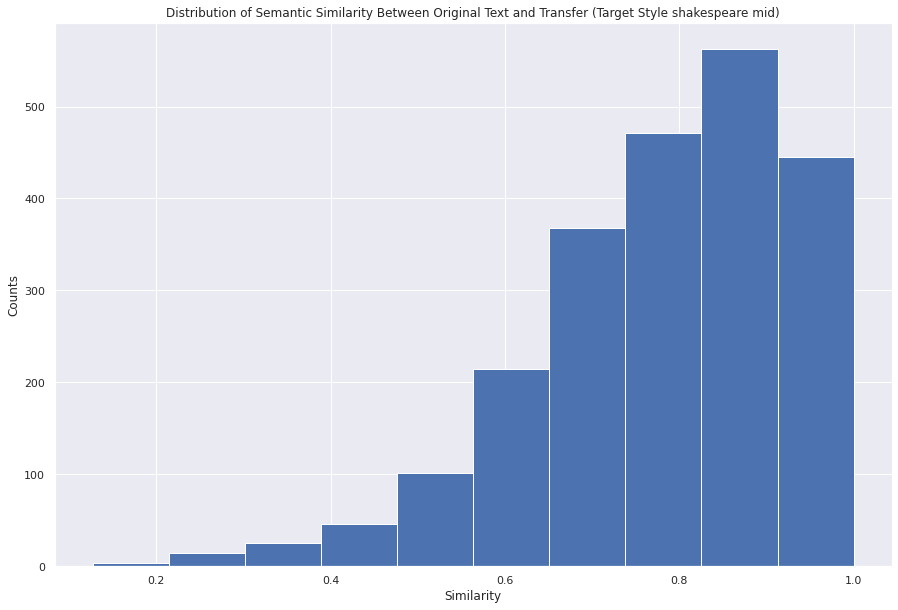

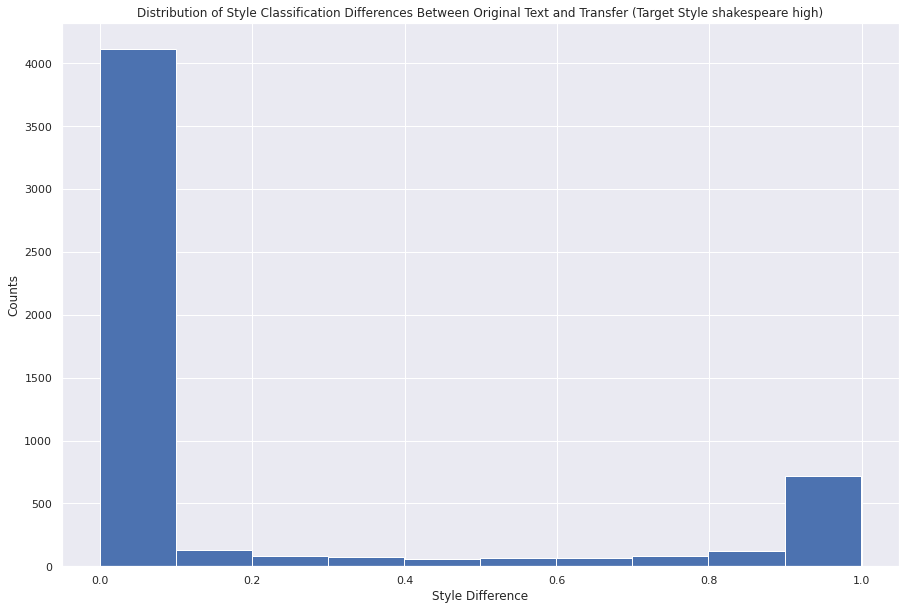

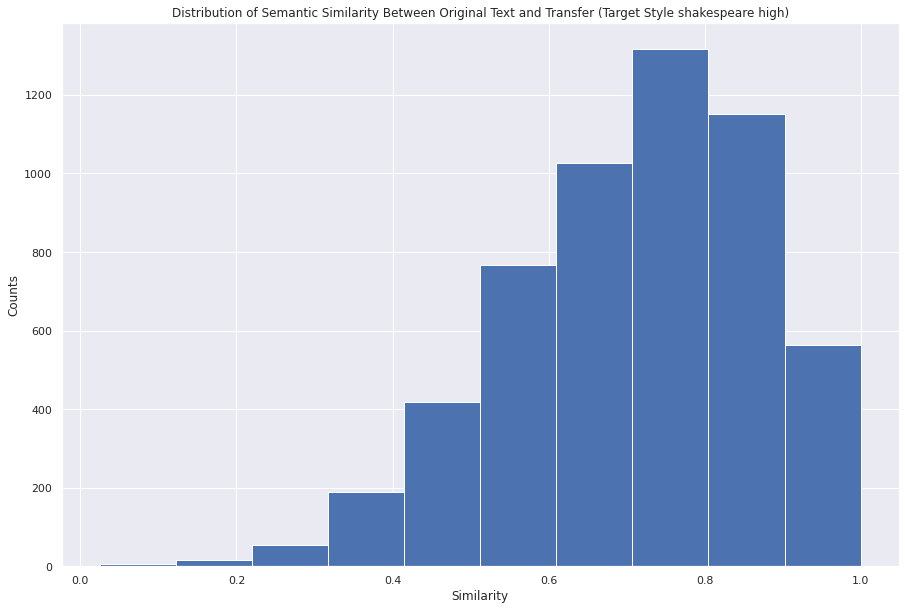

In [62]:
results_dir = f'../results/{dataset}/{mode}'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

fig, axs = plt.subplots(1,1,figsize=(15,10))
axs.set_title(f"Distribution of Style Classification Differences Between Original Text and Transfer {dataset}")
axs.set_xlabel(f"Style Difference")
axs.set_ylabel(f"Counts")
plt.hist(parallel_df['shakespeare_orig_diff_max'].values, density=False);
plt.savefig(os.path.join(results_dir, f'{dataset}_orig_diffs.png'))

fig, axs = plt.subplots(1,1,figsize=(15,10))
axs.set_title(f"Distribution of Semantic Similarity Between Original Text and Transfer (Target Style {dataset} {target_style})")
axs.set_xlabel(f"Similarity")
axs.set_ylabel(f"Counts")
plt.hist(parallel_df['best_sim_orig'].values, density=False);
plt.savefig(os.path.join(results_dir, f'{dataset}_orig_sims.png'))

with open(os.path.join(results_dir, f'{dataset}_{mode}_orig_diffs.md'), 'w') as summaryfile:
    summaryfile.write(f"## Summary Stats for {dataset} {mode}\n")
    summaryfile.write('| Metric     | Mean | Std Dev|\n')
    summaryfile.write('| ----------- | ----------- |--------|\n')
    summaryfile.write(f"| Style difference between original and transfers | {parallel_df[f'{dataset}_orig_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_orig_diff_max'].std(): .4f} |\n")
    summaryfile.write(f"| Style difference between paraphrase and transfers | {parallel_df[f'{dataset}_para_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_para_diff_max'].std(): .4f} |\n")
    summaryfile.write(f"| Semantic similarity between original and transfers | {parallel_df['best_sim_orig'].mean(): .4f} | {parallel_df['best_sim_orig'].std(): .4f} |\n")
    summaryfile.write(f"| Semantic similarity between paraphrase and transfers | {parallel_df['best_sim_para'].mean(): .4f} | {parallel_df['best_sim_para'].std(): .4f} |\n")

for target_style in parallel_df['oring_bucket'].unique().tolist():
    fig, axs = plt.subplots(1,1,figsize=(15,10))
    axs.set_title(f"Distribution of Style Classification Differences Between Original Text and Transfer (Target Style {dataset} {target_style})")
    axs.set_xlabel(f"Style Difference")
    axs.set_ylabel(f"Counts")
    plt.hist(parallel_df[parallel_df['oring_bucket']==target_style]['shakespeare_orig_diff_max'].values, density=False);
    plt.savefig(os.path.join(results_dir, f'{dataset}_{target_style}_orig_diffs.png'))
    
    fig, axs = plt.subplots(1,1,figsize=(15,10))
    axs.set_title(f"Distribution of Semantic Similarity Between Original Text and Transfer (Target Style {dataset} {target_style})")
    axs.set_xlabel(f"Similarity")
    axs.set_ylabel(f"Counts")
    plt.hist(parallel_df[parallel_df['oring_bucket']==target_style]['best_sim_orig'].values, density=False);
    plt.savefig(os.path.join(results_dir, f'{dataset}_{target_style}_orig_sims.png'))
    
    filtered = parallel_df[parallel_df['oring_bucket']==target_style]
    with open(os.path.join(results_dir, f'{dataset}_{mode}_{target_style}_orig_diffs.md'), 'w') as summaryfile:
        summaryfile.write(f"## Summary Stats for {dataset} {mode} (Target Style {dataset} {target_style})\n")
        summaryfile.write('| Metric     | Mean | Std Dev|\n')
        summaryfile.write('| ----------- | ----------- |--------|\n')
        summaryfile.write(f"| Style difference between original and transfers | {filtered[f'{dataset}_orig_diff_max'].mean() : .4f} | {filtered[f'{dataset}_orig_diff_max'].std(): .4f} |\n")
        summaryfile.write(f"| Style difference between paraphrase and transfers | {filtered[f'{dataset}_para_diff_max'].mean() : .4f} | {filtered[f'{dataset}_para_diff_max'].std(): .4f} |\n")
        summaryfile.write(f"| Semantic similarity between original and transfers | {filtered['best_sim_orig'].mean(): .4f} | {filtered['best_sim_orig'].std(): .4f} |\n")
        summaryfile.write(f"| Semantic similarity between paraphrase and transfers | {filtered['best_sim_para'].mean(): .4f} | {filtered['best_sim_para'].std(): .4f} |\n")

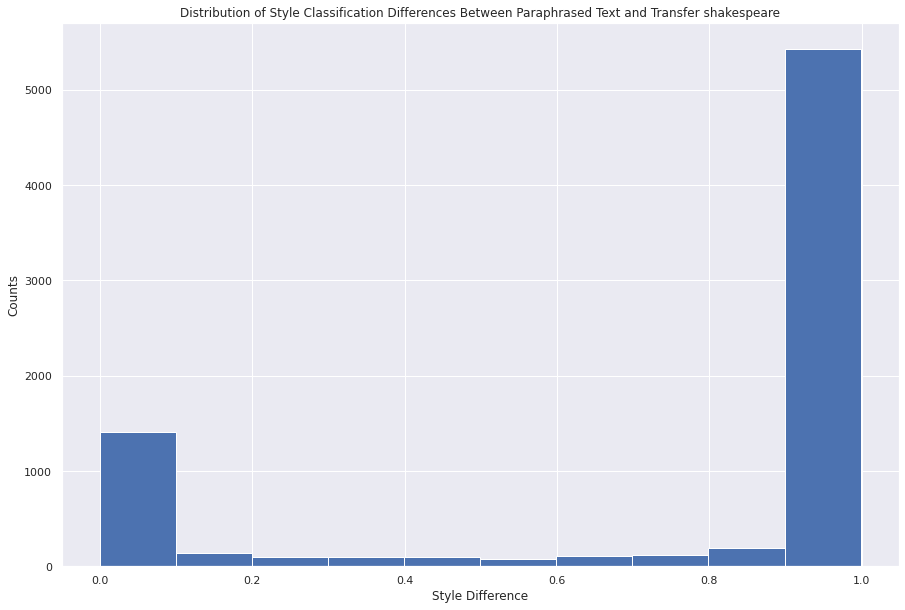

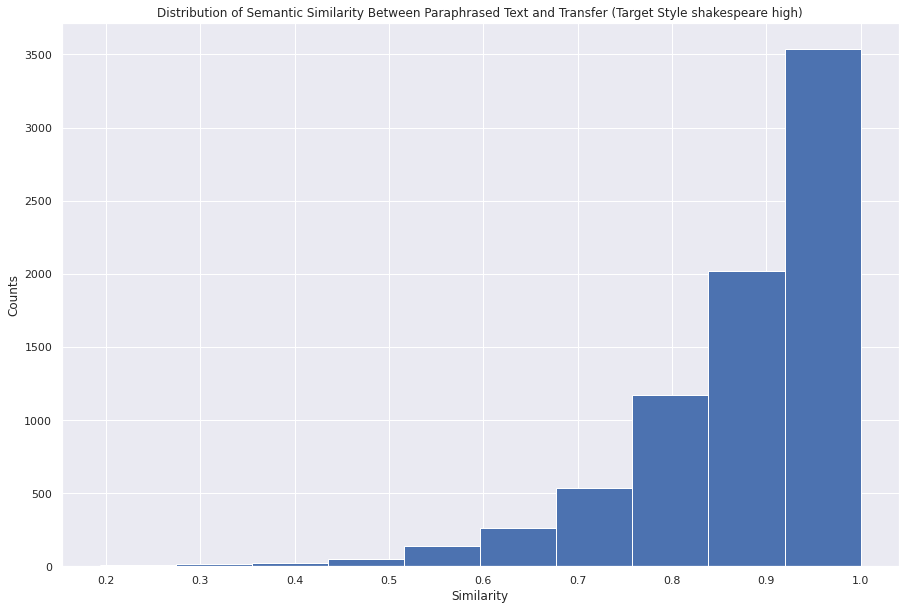

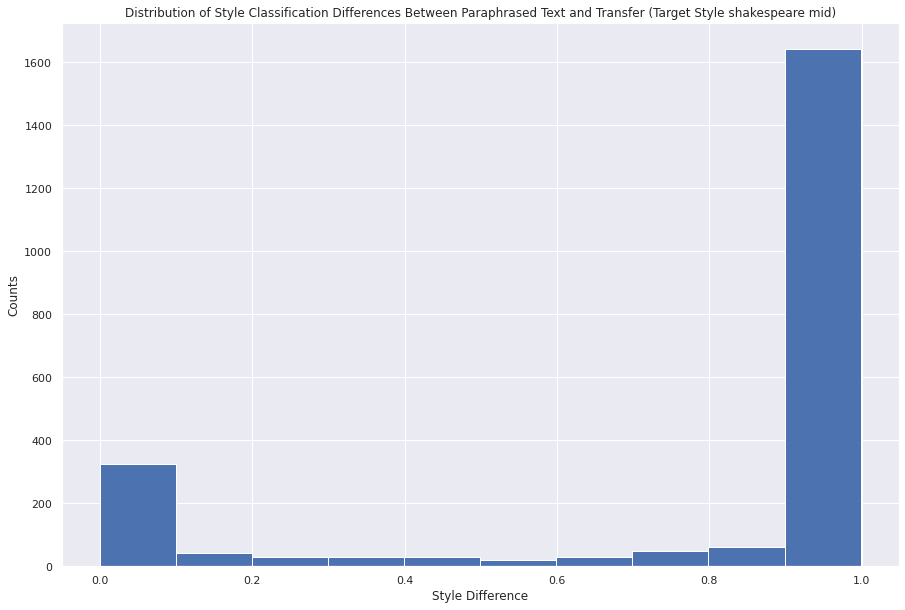

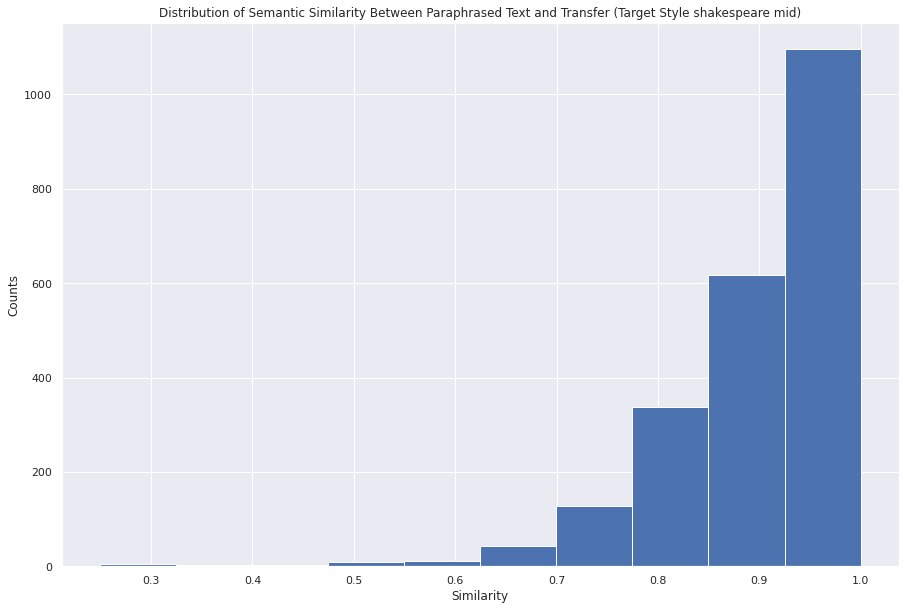

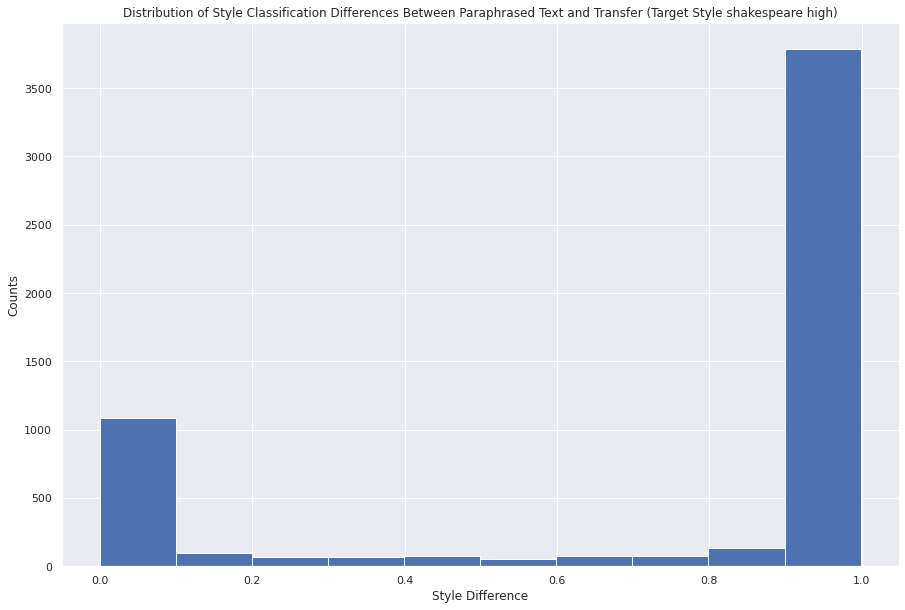

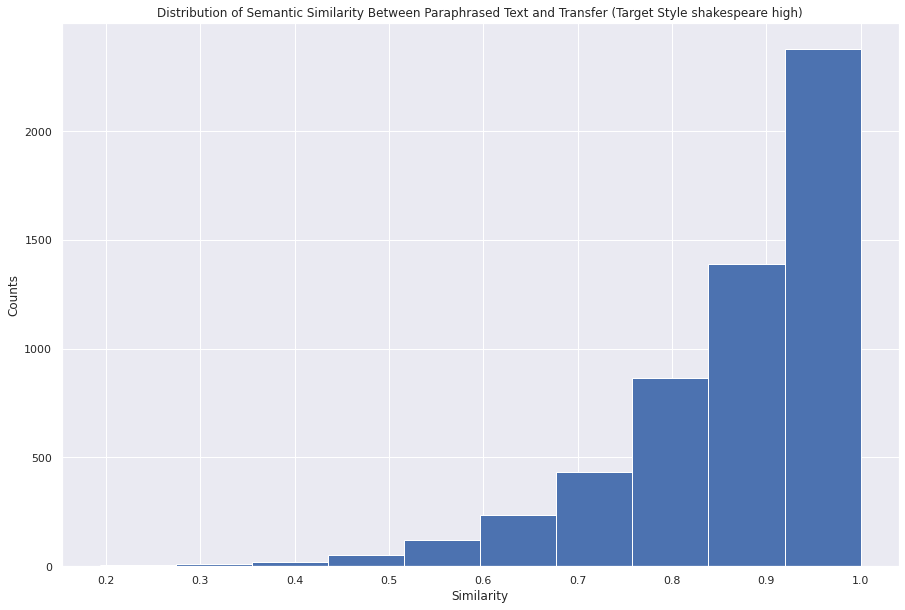

In [63]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
axs.set_title(f"Distribution of Style Classification Differences Between Paraphrased Text and Transfer {dataset}")
axs.set_xlabel(f"Style Difference")
axs.set_ylabel(f"Counts")
plt.hist(parallel_df['shakespeare_para_diff_max'].values, density=False);
plt.savefig(os.path.join(results_dir, f'{dataset}_para_diffs.png'))

fig, axs = plt.subplots(1,1,figsize=(15,10))
axs.set_title(f"Distribution of Semantic Similarity Between Paraphrased Text and Transfer (Target Style {dataset} {target_style})")
axs.set_xlabel(f"Similarity")
axs.set_ylabel(f"Counts")
plt.hist(parallel_df['best_sim_para'].values, density=False);
plt.savefig(os.path.join(results_dir, f'{dataset}_para_sims.png'))

with open(os.path.join(results_dir, f'{dataset}_{mode}_para_diffs.md'), 'w') as summaryfile:
    summaryfile.write(f"## Summary Stats for {dataset} {mode}\n")
    summaryfile.write('| Metric     | Mean | Std Dev|\n')
    summaryfile.write('| ----------- | ----------- |--------|\n')
    summaryfile.write(f"| Style difference between paraphrased and transfers | {parallel_df[f'{dataset}_para_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_para_diff_max'].std(): .4f} |\n")
    summaryfile.write(f"| Style difference between paraphrase and transfers | {parallel_df[f'{dataset}_para_diff_max'].mean() : .4f} | {parallel_df[f'{dataset}_para_diff_max'].std(): .4f} |\n")
    summaryfile.write(f"| Semantic similarity between paraphrased and transfers | {parallel_df['best_sim_para'].mean(): .4f} | {parallel_df['best_sim_para'].std(): .4f} |\n")
    summaryfile.write(f"| Semantic similarity between paraphrase and transfers | {parallel_df['best_sim_para'].mean(): .4f} | {parallel_df['best_sim_para'].std(): .4f} |\n")

for target_style in parallel_df['oring_bucket'].unique().tolist():
    fig, axs = plt.subplots(1,1,figsize=(15,10))
    axs.set_title(f"Distribution of Style Classification Differences Between Paraphrased Text and Transfer (Target Style {dataset} {target_style})")
    axs.set_xlabel(f"Style Difference")
    axs.set_ylabel(f"Counts")
    plt.hist(parallel_df[parallel_df['oring_bucket']==target_style]['shakespeare_para_diff_max'].values, density=False);
    plt.savefig(os.path.join(results_dir, f'{dataset}_{target_style}_para_diffs.png'))
    
    fig, axs = plt.subplots(1,1,figsize=(15,10))
    axs.set_title(f"Distribution of Semantic Similarity Between Paraphrased Text and Transfer (Target Style {dataset} {target_style})")
    axs.set_xlabel(f"Similarity")
    axs.set_ylabel(f"Counts")
    plt.hist(parallel_df[parallel_df['oring_bucket']==target_style]['best_sim_para'].values, density=False);
    plt.savefig(os.path.join(results_dir, f'{dataset}_{target_style}_para_sims.png'))
    
    filtered = parallel_df[parallel_df['oring_bucket']==target_style]
    with open(os.path.join(results_dir, f'{dataset}_{mode}_{target_style}_para_diffs.md'), 'w') as summaryfile:
        summaryfile.write(f"## Summary Stats for {dataset} {mode} (Target Style {dataset} {target_style})\n")
        summaryfile.write('| Metric     | Mean | Std Dev|\n')
        summaryfile.write('| ----------- | ----------- |--------|\n')
        summaryfile.write(f"| Style difference between paraphrased and transfers | {filtered[f'{dataset}_para_diff_max'].mean() : .4f} | {filtered[f'{dataset}_para_diff_max'].std(): .4f} |\n")
        summaryfile.write(f"| Style difference between paraphrase and transfers | {filtered[f'{dataset}_para_diff_max'].mean() : .4f} | {filtered[f'{dataset}_para_diff_max'].std(): .4f} |\n")
        summaryfile.write(f"| Semantic similarity between paraphrased and transfers | {filtered['best_sim_para'].mean(): .4f} | {filtered['best_sim_para'].std(): .4f} |\n")
        summaryfile.write(f"| Semantic similarity between paraphrase and transfers | {filtered['best_sim_para'].mean(): .4f} | {filtered['best_sim_para'].std(): .4f} |\n")